# Run the calculation:

In [1]:
# on Magique3:
using MPI
addprocs(MPIManager(np=80));

# on CORI:
# using ClusterManagers
# addprocs_slurm(64)

--------------------------------------------------------------------------
directory that appears to be mounted on a network filesystem.
Creating the shared memory backup file on a network file system, such
as NFS or Lustre is not recommended -- it may cause excessive network
traffic to your file servers and/or cause shared memory traffic in
Open MPI to be much slower than expected.

You may want to check what the typical temporary directory is on your
node.  Possible sources of the location of this temporary directory
include the $TEMPDIR, $TEMP, and $TMP environment variables.

Note, too, that system administrators can set a list of filesystems
where Open MPI is disallowed from creating temporary files by settings
the MCA parameter "orte_no_session_dir".

  Local host: bq041
  Fileame:    /wrk/mmillea/openmpi-sessions-mmillea@bq041_0/43169/1/shared_mem_pool.bq041

You can set the MCA paramter shmem_mmap_enable_nfs_warning to 0 to
disable this message.
--------------------------------

In [1]:
@everywhere using CMBLensing
using CMBLensing: ode4
using PyPlot
using PyCall
using JLD

@pyimport seaborn as sns
sns.set_context("paper",font_scale=1.4,rc=Dict("lines.markeredgewidth"=>1))
sns.set_palette("colorblind")
sns.set_style("ticks",Dict("xtick.direction"=>"in","ytick.direction"=>"in"))

In [2]:
cls = class(lmax=8000);

In [3]:
@everywhere function matrix{F<:Field}(::Type{F}, L::LinOp)
    hcat(((F(L*(x=zeros(length(F)); x[i]=1; x)[Tuple{F}]))[:] for i=1:length(F))...);
end

In [4]:
@everywhere begin 
    Θpix, nside, T = 1, 64, Float64
    P = Flat{Θpix,nside}
end

In [22]:
Nℓϕϕ = @. readdlm("../dat/noise_dd.dat")[:]*(2:3000)^-2.
# the file the EB-noise, factor of 10 approximates the temp-only curve
Nℓϕϕ = 10 .* [Nℓϕϕ; @. Nℓϕϕ[end]*((3000:8000)/3000)^-1];

In [5]:
P = Flat{Θpix,nside}

## covariances in the right pixelization
Cϕ = Cℓ_to_cov(T,P,S0,cls[:ℓ], cls[:ϕϕ])

CMBLensing.FullDiagOp{CMBLensing.FlatS0Fourier{Float64,CMBLensing.Flat{1,64}},CMBLensing.Flat{1,64},CMBLensing.S0,CMBLensing.Fourier}(CMBLensing.FlatS0Fourier{Float64,CMBLensing.Flat{1,64}}(Complex{Float64}[0.0+0.0im 1.3469e-17+0.0im … 3.01489e-19+0.0im 1.3469e-17+0.0im; 1.3469e-17+0.0im 2.09333e-18+0.0im … 1.60169e-19+0.0im 2.09333e-18+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im]))

In [8]:
ϕ = simulate(Cϕ)

CMBLensing.FlatS0Fourier{Float64,CMBLensing.Flat{1,64}}(Complex{Float64}[-0.0+0.0im -3.61828e-12+1.07773e-11im … -1.54544e-12+8.13523e-13im -3.61828e-12-1.07773e-11im; 7.0656e-12-5.02151e-12im -3.51654e-12+1.89892e-12im … 1.67325e-13+7.00386e-13im 2.29157e-12-4.79154e-12im; … ; -0.0+0.0im 0.0-0.0im … -0.0+0.0im 0.0-0.0im; -0.0+0.0im -0.0+0.0im … 0.0+0.0im 0.0-0.0im])

In [10]:
real(logdet(complex(matrix(FlatS0Map{T,P},PowerLens{7}(0.1ϕ)))))

-2.9971784400772985

In [11]:
nsides = [8,16,32,64]

@time dat = map(nsides) do nside 

    P = Flat{Θpix,nside}
    
    ## covariances in the right pixelization
    Cϕ = Cℓ_to_cov(T,P,S0,cls[:ℓ], cls[:ϕϕ])
    Nϕ = Cℓ_to_cov(T,P,S0,2:8001, Nℓϕϕ)
    
    # our expected best-fit ϕ comes from S(S+N)⁻¹S
    ϕwf = simulate(@. nan2zero(Cϕ * (Cϕ + Nϕ)^-1 * Cϕ))
    
    L = PowerLens{7}
    
    pmap(1:160) do _ 
        # samples from the posterior come from an additional S(S+N)⁻¹N ontop of that
        let ϕ = ϕwf + simulate(@. nan2zero(Cϕ * (Cϕ + Nϕ)^-1 * Nϕ))
            ϕ⋅(Squash*(Cϕ\ϕ)), real(logdet(complex(matrix(FlatS0Map{T,P},L(ϕ)))))
        end
    end
end;

201.361629 seconds (309.98 k allocations: 40.793 MiB, 0.03% gc time)


In [12]:
save("../dat/lnP_terms_1arcmin_pl7.jld","dat",dat)

# Make the plot:

In [16]:
dat = load("../dat/lnP_terms_1arcmin_pl7.jld","dat");

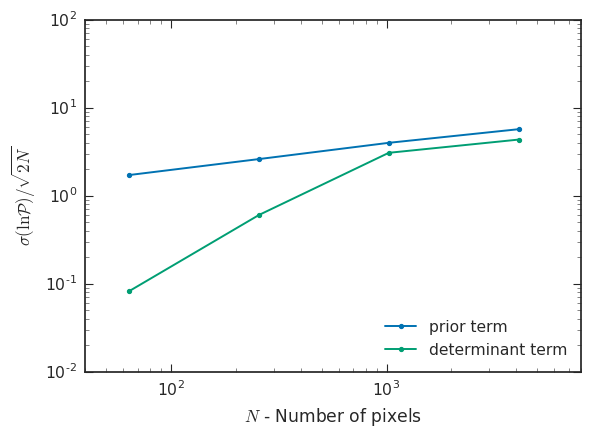

In [18]:
loglog(nsides.^2, [std(getindex.(d,1)) for d=dat]./(√2nsides), ".-")
loglog(nsides.^2, [std(getindex.(d,2)) for d=dat]./(√2nsides), ".-")  


legend(["prior term","determinant term"],loc="lower right")
ylim(1e-2,1e2)
yscale("log")
xlabel(raw"$N$ - Number of pixels")
ylabel(raw"$\sigma(\ln \mathcal{P}) / \sqrt{2N}$")
xlim(40,8e3)
savefig("../paper/figs/lnP_terms.pdf",bbox_inches="tight")